# Förderhinweis

Dieses Dokument ist Teil des Lehrmaterials für die **Zusatzqualifikation KI und Maschinelles Lernen.** 

Die Entwicklung und Erprobung dieses Bildungsangebotes wurde vom Bundesministerium für Bildung und Forschung im Rahmen des InnoVET-Programms gefördert.

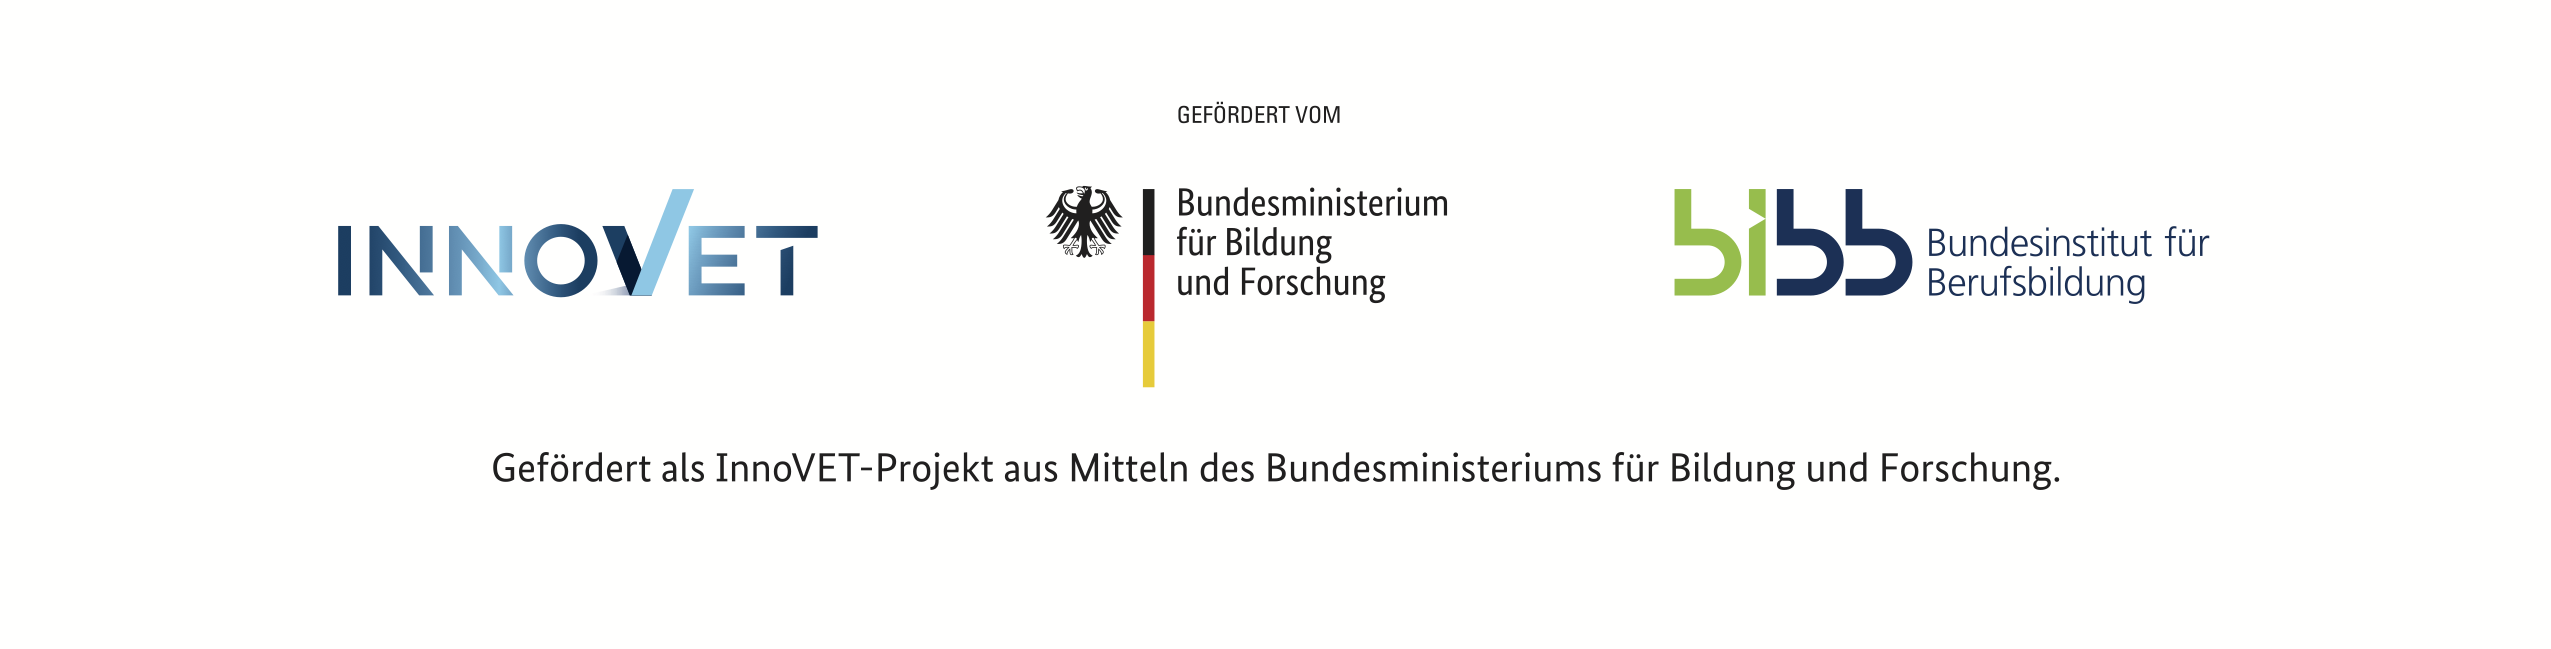

# Lizenzhinweis

Dieses Notebook "Parameter beim Training von Klassifikationsbäumen: Klassifikationsbäume, Teil 2" wurde von Antje Schweitzer, KI B3 / Universität Stuttgart, erstellt. 

Das Werk, mit Ausnahme der oben abgebildenten Förderlogos, ist lizenziert unter [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/deed.de) (Namensnennung 4.0 International)

# Parameter beim Training von Entscheidungsbäumen: Klassifikationsbäume, Teil 2

Beim Training von Entscheidungsbäumen ist es wichtig, die Bäume nicht sinnlos groß oder detailliert werden zu lassen, vor allem, wenn in den zu modellierenden Daten zufällige Variation enthalten ist. 

Dieses Problem heißt **Overfitting**. 

Dieses Notebook illustriert das Problem und führt Parameter ein, mit denen Overfitting beim Training von Entscheidungsbäumen reduziert werden kann. 

## Beispieldaten vorbereiten

Wir bauen als erstes zwei Klassifikationsbäume für die Öffnung des Eisstands, und zwar, vereinfacht gesagt, einen für gerade Tage, einen für ungerade Tage. 

Dadurch bekommen wir zwei Mengen von Daten, die aus den gleichen jahreszeitlichen Bedingungen stammen und daher auch denselben Einflüssen unterliegen sollten. Regelmäßigkeiten, die für die eine Menge gelten, sollten auch für die andere gelten. 

Eigentlich sollte man daher erwarten, dass sich also in etwa derselbe Baum ergibt, egal, ob man als Datengrundlage die geraden oder die ungeraden Tage verwendet. 

Wir wollen hier vergleichen, wie ähnlich diese Bäume tatsächlich werden. 


In [ ]:
# für DataFrames
import pandas

Wir laden die Daten, trennen sie aber auf in zwei Teile: einmal alle Zeilen, die in den Eisvekaufsdaten ursprünglich einen geraden Index hatten, und einmal alle Zeilen, die in den Eisverkaufsdaten ursprünglich einen ungeraden Index hatten. 

Für die "geraden" Tage behalten wir einfach jede 2. Zeile: in `loc[::2]` bedeutet das `::2` "jedes 2. Element". Da wir bei Index 0 starten, wie in Python üblich, ergibt das genau die Daten, die in den usprünglichen Eisdaten einen geraden Index hatten. 

Im [ersten Notebook zum Training von Klassifikationsbäumen](https://colab.research.google.com/drive/1JP7m_I2jtyIuffvJzODuokzRPzrF15GH?usp=sharing) waren wir genauso vorgegangen, um nur jeden 11. Datenpunkt zu laden. 

Für die "ungeraden" Tage, also Tage, die in den Eisdaten einen ungeraden Index hatten, gehen wir genauso vor, allerdings starten wir nicht von vorne bei Index 0, sondern beim Index 1, also beim zweiten Element: `loc[1::2]`. 

In [ ]:
import pandas

# Wetterdaten laden
wetter_url = 'https://github.com/antje-schweitzer/wetterdaten/raw/main/wetterdaten.csv'
wetter = pandas.read_csv(wetter_url)

# Eisdaten laden
eisdaten = pandas.read_csv('https://github.com/antje-schweitzer/eisverkauf2018/raw/main/eisverkauf.2018.csv')
# nur jede 2. Zeile behalten
eisdaten_gerade = eisdaten.loc[::2]
eisdaten_ungerade = eisdaten.loc[1::2]

# Wetter- und Eisdaten zusammenführen
daten_gerade = pandas.merge(wetter,eisdaten_gerade,left_on='Datum',right_on='Datum')
daten_ungerade = pandas.merge(wetter,eisdaten_ungerade,left_on='Datum',right_on='Datum')

# erste Zeilen anzeigen, damit man überprüfen kann, ob die Daten stimmen
print("Gerade: -------")
print(daten_gerade.head())
print("Ungerade: -------")
print(daten_ungerade.head())


Gerade: -------
        Datum   Max  Wolken  Wochentag  Portionen
0  2018-01-01   9.4     6.6          1        0.0
1  2018-01-03  13.1     7.6          3       80.0
2  2018-01-05  11.5     7.7          5       27.0
3  2018-01-07   6.9     7.9          0       20.0
4  2018-01-09   8.0     7.5          2        0.0
Ungerade: -------
        Datum   Max  Wolken  Wochentag  Portionen
0  2018-01-02   6.9     7.6          2        0.0
1  2018-01-04  12.5     7.7          4       35.0
2  2018-01-06  10.1     7.5          6      106.0
3  2018-01-08   7.4     7.0          1        0.0
4  2018-01-10  10.8     7.9          3        8.0


Wir ersparen uns diesmal das Runden, aber wir ergänzen wieder eine Spalte für 'Wochenende' sowie eine Spalte mit der gewünschten Klasse 'Zustand'. 

In [ ]:
# aus den Wochentagen die Info über Wochenende ableiten und als 0 bzw. 1 speichern
daten_gerade['Wochenende']=daten_gerade['Wochentag'].replace([0,1,2,3,4,5,6],[1,0,0,0,0,0,1])
daten_ungerade['Wochenende']=daten_ungerade['Wochentag'].replace([0,1,2,3,4,5,6],[1,0,0,0,0,0,1])

# Die korrekte Klasse in der Spalte Zustand ergänzen: 
daten_gerade.loc[daten_gerade['Portionen']>=100,'Zustand']='offen'
daten_gerade.loc[daten_gerade['Portionen']<100,'Zustand']='geschlossen'
daten_ungerade.loc[daten_ungerade['Portionen']>=100,'Zustand']='offen'
daten_ungerade.loc[daten_ungerade['Portionen']<100,'Zustand']='geschlossen'

# NA Werte loswerden (sonst gibt es Fehler beim Training des Baums)
daten_gerade = daten_gerade.dropna(axis=0)
daten_ungerade = daten_ungerade.dropna(axis=0)

## Zwei Klassifikationsbäume erstellen

Wir können nun mit dem selben Code wie im [ersten Notebook zum Training von Klassifikationsbäumen](https://colab.research.google.com/drive/1JP7m_I2jtyIuffvJzODuokzRPzrF15GH?usp=sharing) die Bäume trainieren. Wir erstellen diesmal aber zwei Tabellen mit erklärenden Variablen, `X1` und `X2`, und zwei Vektoren mit abhängigen (vorherzusagenden) Variablen, `y1` und `y2`. 

Die Bäume nennen wir `baum1` und `baum2`. 

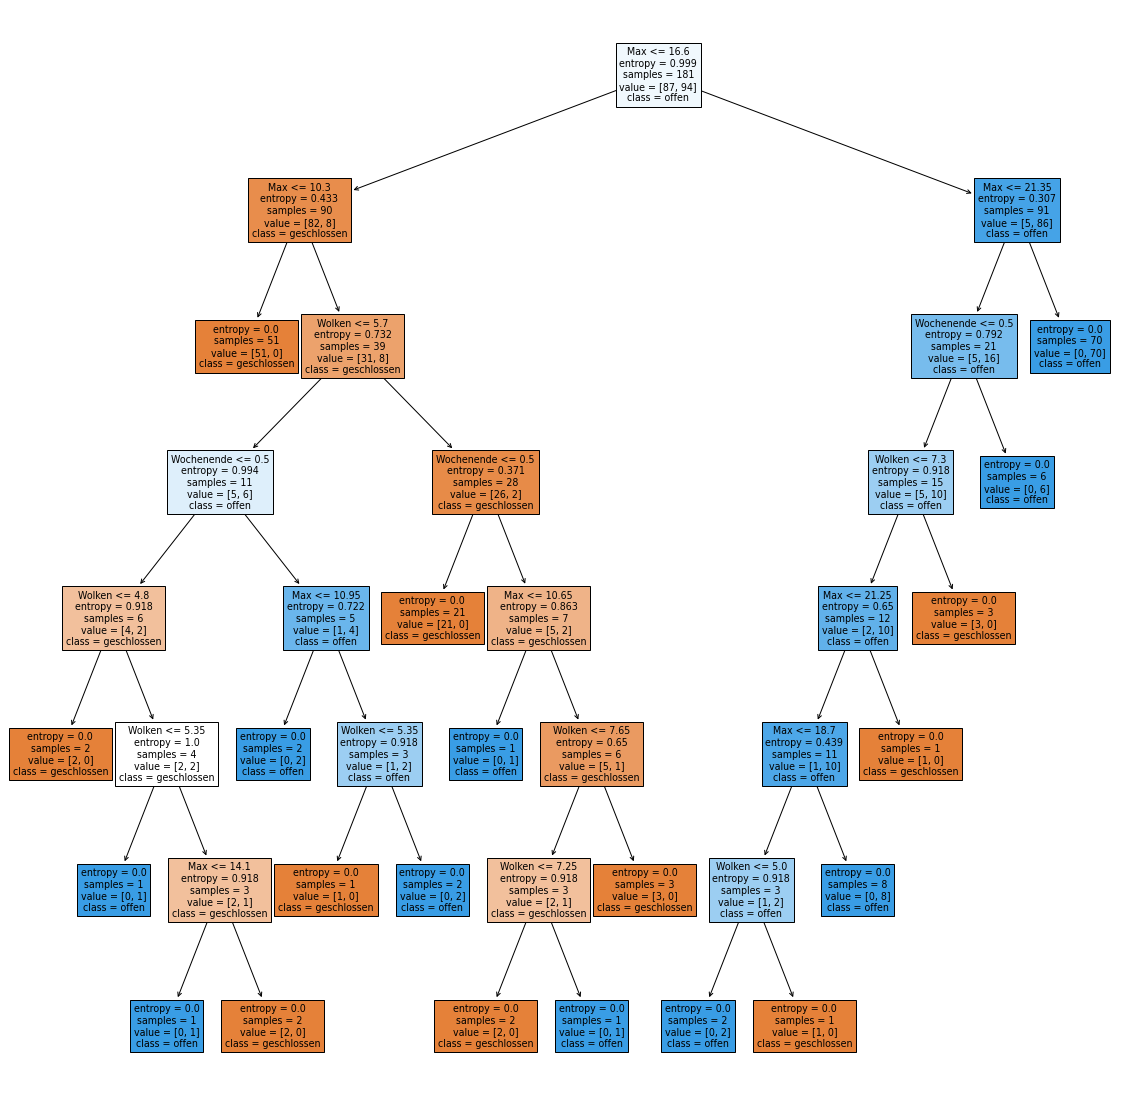

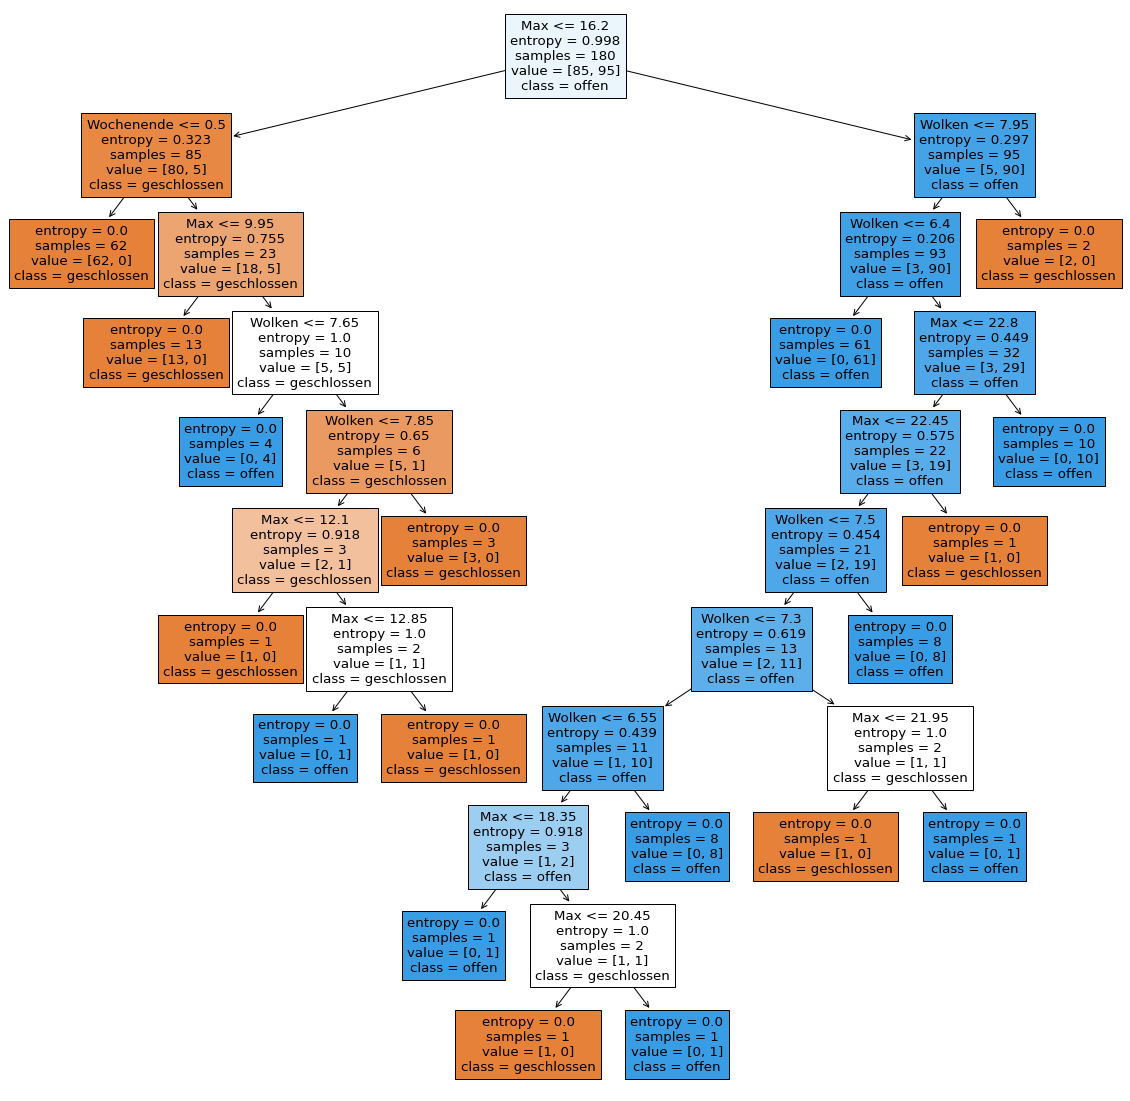

In [ ]:
# Bibliotheken laden
# für Entscheidungsbäume
from sklearn import tree
# für deren grafische Darstellung
from matplotlib import pyplot 

# unabhänige und abhängige Variablen für die geraden Zeilen
X1=pandas.DataFrame(daten_gerade[['Max','Wolken','Wochenende']])
y1=pandas.DataFrame(daten_gerade[['Zustand']])

# unabhänige und abhängige Variablen für die ungeraden Zeilen
X2=pandas.DataFrame(daten_ungerade[['Max','Wolken','Wochenende']])
y2=pandas.DataFrame(daten_ungerade[['Zustand']])

features = ['Max','Wolken','Wochenende']
# müssen in alphabetischer Reihenfolge sein!
klassen = ['geschlossen','offen']

# Baum für gerade Zeilen
baum1 = tree.DecisionTreeClassifier(criterion='entropy')
baum1.fit(X1, y1)

# Baum für ungerade Zeilen 
baum2 = tree.DecisionTreeClassifier(criterion='entropy')
baum2.fit(X2, y2)

# Baum grafisch darstellen
pyplot.figure(figsize=(20,20))
tmp = tree.plot_tree(baum1,feature_names=features,class_names=klassen,filled=True)
pyplot.figure(figsize=(20,20))
tmp = tree.plot_tree(baum2,feature_names=features,class_names=klassen,filled=True)


Die beiden Bäume weisen Gemeinsamkeiten auf: beide teilen die Daten am ersten Knoten aufgrund des Features 'Max' auf, und auch bei ähnlichen Werten: beim ersten Baum bei 16.6, beim zweiten bei 16.2 Grad. 

Man kann auch gut sehen, dass in beiden Fällen im linken Teilbaum die organgefarbenen Knoten dominieren: d.h. hier sind vor allem Datenpunkte mit Zustand 'geschlossen' gelandet, während im rechten Teilbaum für die höheren Temperaturen viele blaue Knoten sind, also 'offen'. 

Die beiden Bäume unterscheiden sich im Detail aber sehr stark. 

Da nicht anzunehmen ist, dass sich die Gesetzmäßigkeiten des Eisverkaufs an geraden Tagen anders zeigen als an ungeraden, kann man hier nur schließen, dass beim Eisverkauf auch Zufall im Spiel ist, und dieser Zufallseffekt ist eben von Tag zu Tag verschieden. Dadurch ergibt sich in den Daten eine gewisse zufällige Variation. 

Nun macht es natürlich keinen Sinn, den Zufall in einem Entscheidungsbaum zu modellieren. Genau dies ist hier aber geschehen: wir haben versucht, den Baum perfekt an die jeweiligen Daten anzupassen, bis auf den letzten Datenpunkt. Diese Problem heißt **Overfitting**. Auf Deutsch findet man auch manchmal den Begriff "Überanpassung". Overfitting ist ein wichtiges Thema beim Maschinellen Lernen, und es gibt viele Techniken, mit denen man Overfitting verhindern kann. 

Wir sehen uns hier verschiedene Parameter an, die helfen können, Overfitting bei Entscheidungsbäumen zu umgehen.

---

**Overfitting bezeichnet die zu perfekte Anpassung eines KI-Modells auf die Trainingsdaten.**

---

## Vermeidung von Overfitting bei Entscheidungsbäumen

Wie oben erklärt, haben wir bisher immer versucht, wirklich alle Datenpunkte korrekt zu klassifizieren: dadurch haben wir oft Blätter bekommen, die nur noch sehr wenige Daten enthielten, oft nur noch einen Datenpunkt. Und die Bäume sind sehr groß geworden: sie sind erstens sehr tief (d.h. es gibt viele Ebenen im Baum - anders ausgedrückt: sehr lange Pfade vom obersten Knoten bis zu besonders tief liegenden Blättern), und sie haben zweitens eben sehr viele Blätter. 

Genau diese Faktoren können wir durch verschiedene Parameter bereits beim Bauen kontrollieren. Fangen wir mit der Tiefe des Baums an. 



### Tiefe des Baums

Die Bäume oben waren sehr tief, d.h., sie hatten viele "Ebenen". Beim ersten Baum z.B. musste man bis zu 7 mal verzweigen, um an einem Blatt zu landen, d.h. inklusive des Blattes waren 8 "Ebenen" vorhanden vom Wurzelknoten bis zum Blatt - man spricht von einer Tiefe von 7. Beim zweiten Baum war die Tiefe sogar 9. 

Wir können nun beim Erstellen des Baums bereits angeben, dass eine bestimmte Tiefe nicht überschritten werden darf. Das bedeutet, dass keine weiteren Verzweigungen mehr eingefügt werden, wenn die maximale Tiefe erreicht ist, es wird statt dessen ein Blatt eingefügt, das dann eben nicht nur Daten einer Klasse enthält, das also noch "unordentlich" ist. 

Der Parameter wird in `sklearn` als `max_depth` bezeichnet und beim Initialisieren des Baums angegeben. Wir probieren hier als maximale Tiefe 3 aus:

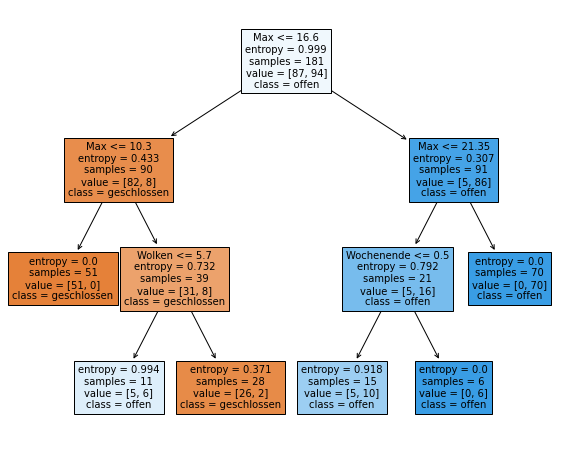

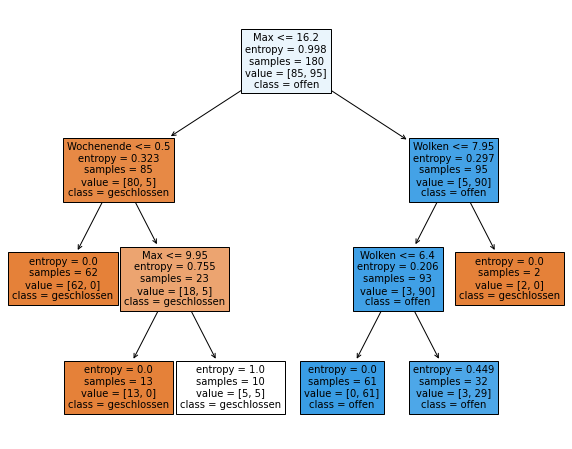

In [ ]:

# Baum für gerade Zeilen
baum1_max_depth = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)
baum1_max_depth.fit(X1, y1)

# Baum für ungerade Zeilen 
baum2_max_depth = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)
baum2_max_depth.fit(X2, y2)

# Baum grafisch darstellen
pyplot.figure(figsize=(10,8))
tmp = tree.plot_tree(baum1_max_depth,feature_names=features,class_names=klassen,filled=True)
pyplot.figure(figsize=(10,8))
tmp = tree.plot_tree(baum2_max_depth,feature_names=features,class_names=klassen,filled=True)


Es gibt immer noch Unterschiede zwischen den beiden Bäumen, allerdings weniger. Beachten Sie, dass im oberen Baum sämtliche Knoten auf der rechten Seite blau sind - hier wird überall als Klasse offen vorhergesagt, auch wenn der Baum nochmal feiner unterteilt ist, weil dadurch die Entropien für die jeweiligen Aufteilungen optimal sind. Dennoch kann man sich den Baum eigentlich so vorstellen, als gäbe es rechts unter dem Wurzelknoten nur ein blaues Blatt für 'offen'. 

Analog sieht es auf der linken Seite des zweiten Baums aus - hier wird überall 'geschlossen' vorhergesagt. 

Die Bäume sind sich also nur in Details nicht einig: der obere bietet für ein paar Datenpunkte im rechten Teilbaum doch noch 'offen' als Vorhersage; der untere dagegen klassifiziert 2 Datenpunkte im rechten Teilbaum als 'geschlossen'. 

Vermutlich liegt also immer noch leichtes Overfitting vor - wie wir das herausfinden, wird in späteren Materialien noch Thema sein. 

### Maximale Zahl von Blättern

Ein weiterer Parameter, der direkt auf die Größe des Baumes zielt, ist die maximale Zahl von Blättern. Auch diese kann bei `sklearn` für Entscheidungbäume eingeschränkt werden, durch Angabe des Parameters `max_leaf_nodes`. 

Der Code ist derselbe wie oben, nur der Parameter lautet anders - wir probieren hier 5 als maximale Zahl von Knoten. 

Das Ergebnis ist sehr ähnlich zum vorigen Abschnitt, als wir die maximale Tiefe vorgegeben haben: 

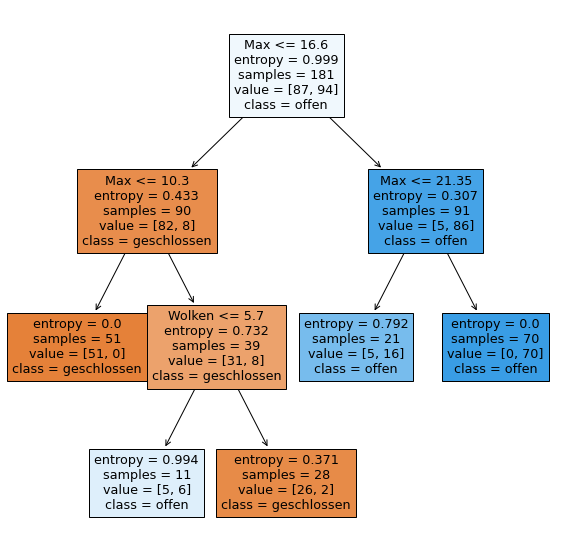

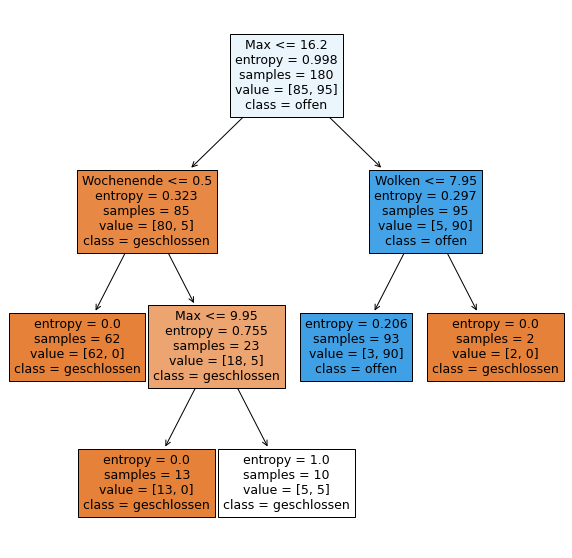

In [ ]:
# Baum für gerade Zeilen
baum1_max_leaf_nodes = tree.DecisionTreeClassifier(criterion='entropy',max_leaf_nodes=5)
baum1_max_leaf_nodes.fit(X1, y1)

# Baum für ungerade Zeilen 
baum2_max_leaf_nodes = tree.DecisionTreeClassifier(criterion='entropy',max_leaf_nodes=5)
baum2_max_leaf_nodes.fit(X2, y2)

# Baum grafisch darstellen
pyplot.figure(figsize=(10,10))
tmp = tree.plot_tree(baum1_max_leaf_nodes,feature_names=features,class_names=klassen,filled=True)
pyplot.figure(figsize=(10,10))
tmp = tree.plot_tree(baum2_max_leaf_nodes,feature_names=features,class_names=klassen,filled=True)


### Mindestmenge von Datenpunkten für Aufteilung


Ein weiterer Parameter, der indirekt auch eine Auswirkung auf die Gesamtgröße des Baums hat, ist die Mindestmenge von Datenpunkten, die vorhanden sein muss, damit an einem Knoten weiter aufgeteilt wird.

Dies bewirkt, dass nur dann feiner aufgeteilt wird, wenn genügend Daten vorhanden sind. Dadurch wird also in manchen Fällen nicht mehr aufgeteilt, sondern ein Blatt eingefügt, auch wenn noch keine perfekte "Ordnung" herrscht. Die Blätter haben also eine höhere Entropie. Dafür wird aber der Baum kleiner. 

Der Parameter heißt in `sklearn` `min_samples_split`. Wir probieren hier 50 als Vorgabe aus - wir sollten also keinen verzweigenden Knoten erhalten, an dem weniger als 50 Datenpunkte vorhanden sind, also weniger als 50 "Samples". 

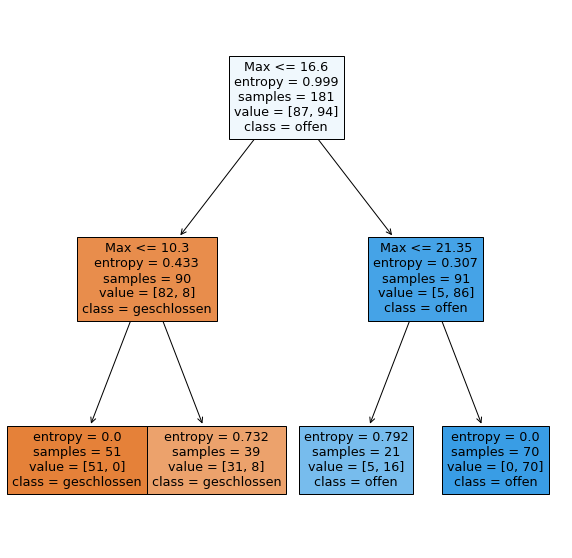

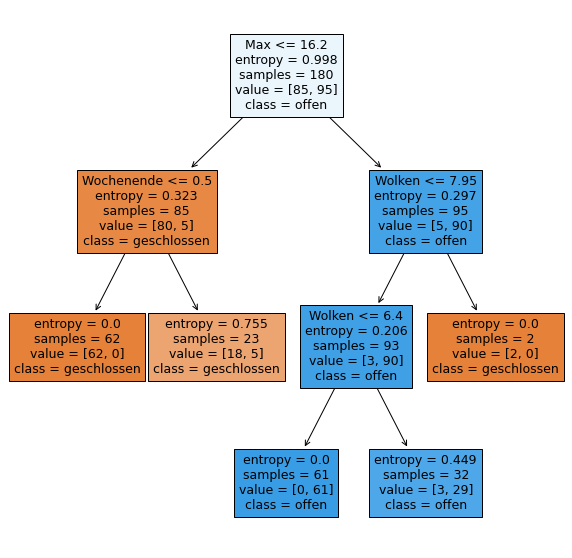

In [ ]:

# Baum für gerade Zeilen
baum1_min_samples_split = tree.DecisionTreeClassifier(criterion='entropy',min_samples_split=50)
baum1_min_samples_split.fit(X1, y1)

# Baum für ungerade Zeilen 
baum2_min_samples_split = tree.DecisionTreeClassifier(criterion='entropy',min_samples_split=50)
baum2_min_samples_split.fit(X2, y2)

# Baum grafisch darstellen
pyplot.figure(figsize=(10,10))
tmp = tree.plot_tree(baum1_min_samples_split,feature_names=features,class_names=klassen,filled=True)
pyplot.figure(figsize=(10,10))
tmp = tree.plot_tree(baum2_min_samples_split,feature_names=features,class_names=klassen,filled=True)


Der Effekt ist wieder ähnlich: der obere Baum klassifiziert grundsätzlich alle Datenpunkte mit weniger als 16.6 Grad als geschlossen, alle anderen als offen. 

Der untere Baum ist sehr ähnlich, hat lediglich als Schwellwert 16.2 statt 16.6 Grad. Und er klassifiziert 2 Datenpunkte bei mehr als 16.2 Grad als geschlossen, und zwar, wenn die Bewölkung sehr stark ist. Wir haben hier also ein Blatt mit sehr wenigen Datenpunkten - aber wir haben ja auch nur sicher gestellt, dass es an verzweigenden Knoten immer genügend Datenpunkte gibt, über Blätter haben wir nichts gesagt. 

Aber auch dafür gibt es einen Parameter:

### Mindestmenge von Datenpunkten an Blättern 

Der Parameter, der für die Blätter eine Mindestmenge von Datenpunkten vorgibt, heißt `min_samples_leaf`. 

Wir probieren 15 als Wert aus und erhalten nun zwei Bäume, die zwar unterschiedlich strukturiert sind, aber fast dieselbe Klassifizierung liefern: der obere klassifiziert alles unter 16.6 Grad als geschlossen, der untere alles unter 16.2 Grad. 

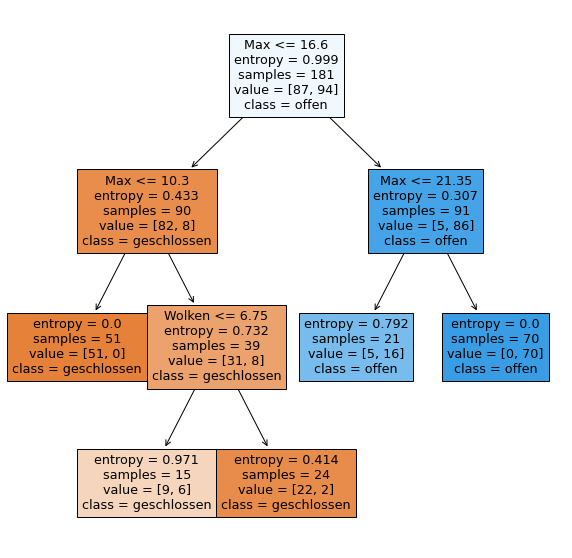

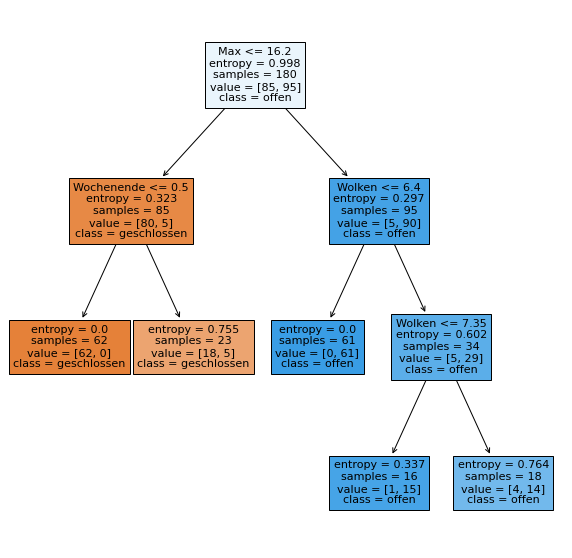

In [ ]:

# Baum für gerade Zeilen
baum1_min_samples_leaf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=15)
baum1_min_samples_leaf.fit(X1, y1)

# Baum für ungerade Zeilen 
baum2_min_samples_leaf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=15)
baum2_min_samples_leaf.fit(X2, y2)

# Baum grafisch darstellen
pyplot.figure(figsize=(10,10))
tmp = tree.plot_tree(baum1_min_samples_leaf,feature_names=features,class_names=klassen,filled=True)
pyplot.figure(figsize=(10,10))
tmp = tree.plot_tree(baum2_min_samples_leaf,feature_names=features,class_names=klassen,filled=True)


### Pruning von Entscheidungsbäumen

Die Parameter, die wir bisher angeschaut haben, waren Parameter, die direkt beim Erstellen des Baums verhindert haben, dass der Baum groß wurde. 

Eine weitere Möglichkeit ist es, den Baum erst zu bauen, und anschließend wieder zu vereinfachen. Dies nennt sich **Pruning**, genauer gesagt **Post-Pruning**. Das Wort Pruning kommt aus dem Englischen und bezeichnet eigentlich das Beschneiden von echten Bäumen, um einen schöneren Wuchs zu bekommen. 

Von Post-Pruning spricht man deshalb, weil man das Pruning **nach** dem eigentlichen Erstellen macht (von lateinisch *post* = "nach"). 

Die weiter oben vorgestellten Methoden, die Größe des Baums durch Parameter wie die maximale Tiefe usw. direkt beim Bauen zu beeinflussen, nennt man übrigens manchmal auch **Pre-Pruning**. 

---

**Die nachträgliche Vereinfachung von Entscheidungsbäumen bezeichnet man als Pruning (oder auch Post-Pruning).**

**Die Vermeidung von zu komplexen Entscheidungsbäumen schon beim Bauen bezeichnet man als Pre-Pruning.**

---

Ein mögliches Verfahren für (Post-)Pruning ist das sogenannte Cost-Complexity-Pruning. Dabei wird der fertige Baum Schritt für Schritt wieder vereinfacht, und zwar grob gesagt dadurch, dass immer der Unterbaum durch ein Blatt ersetzt wird, bei dem dies den Klassifikationsfehler auf den Trainingsdaten am wenigsten beeinflusst. 

Es wird also sozusagen Schritt für Schritt immer der Teilbaum entfernt, "bei dem es am wenigsten weh tut". 

Außer dem Klassifikationsfehler wird hierbei außerdem die Komplexität des zu entfernenden Teilbaums berücksichtigt. Wie stark der Einfluss der Komplexität genau ist, wird durch einen Parameter ausgedrückt, ber bei `sklearn` `ccp_alpha` heißt. Durch Angabe dieses Paramters erreicht man, dass der Baum nach dem Bauen direkt noch gemäß dem angegeben Wert geprunt wird. Das Finden eines passenden Werts ist etwas knifflig und wird meist mithilfe von zusätzlichen Daten bestimmt - auch darauf werden wir erst in späteren Materialien wieder zurückkommen. 

Hier probieren wir einfach mal 0.1 als Wert. 

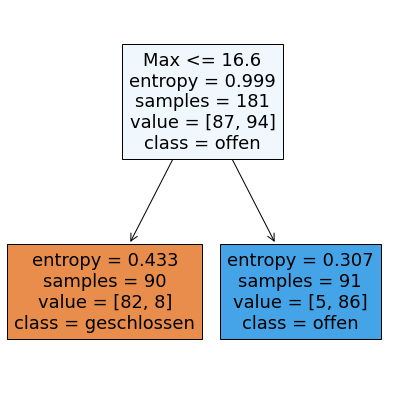

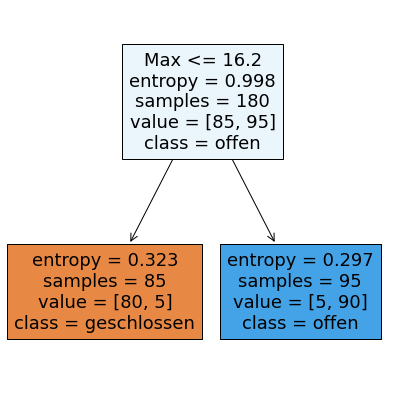

In [ ]:

# Baum für gerade Zeilen
baum1_ccp_alpha = tree.DecisionTreeClassifier(criterion='entropy',ccp_alpha=0.1)
baum1_ccp_alpha.fit(X1, y1)

# Baum für ungerade Zeilen 
baum2_ccp_alpha = tree.DecisionTreeClassifier(criterion='entropy',ccp_alpha=0.1)
baum2_ccp_alpha.fit(X2, y2)

# Baum grafisch darstellen
pyplot.figure(figsize=(7,7))
tmp = tree.plot_tree(baum1_ccp_alpha,feature_names=features,class_names=klassen,filled=True)
pyplot.figure(figsize=(7,7))
tmp = tree.plot_tree(baum2_ccp_alpha,feature_names=features,class_names=klassen,filled=True)


# Zusammenfassung

* **Overfitting** (Überanpassung) bezeichnet die zu perfekte Anpassung eines KI-Modells auf die Trainingsdaten.
* Die nachträgliche Vereinfachung von Entscheidungsbäumen bezeichnet man als **Pruning** (oder auch **Post-Pruning**).
* Die Vermeidung von zu komplexen Entscheidungsbäumen schon beim Bauen bezeichnet man als **Pre-Pruning**.
* Pre-Pruning erreicht man durch Parameter wie z.B. die maximale Baumtiefe oder die maximale Anzahl von Datenpunkten an den Blättern. 
* (Nachträgliches) Pruning kann durch verschiedenen Methoden erreicht werden; ein mögliches Verfahren ist das Cost Complexity Pruning. Hierbei werden nachträglich die Teilbäume durch Blätter ersetzt, bei denen das keinen großen Einfluss auf die Klassifikation hat. 
* Pruning (sowohl Pre- als auch Post-Pruning) ist eine Möglichkeit, Overfitting zu verhindern. 


# Aufgaben



## Vorbereitung

Wir haben schon öfter die Irisdaten verwendet. Bisher haben wir sie immer mit pandas.read_csv eingelesen. Alternativ gibt es diese Daten auch in `sklearn` im Modul `sklearn.datasets`. Dort gibt es die Funktion `load_iris`, die ein Paar von Objekten zurückgibt: die erklärenden Variablen (also die Blattmaße) sowie einen Vektor mit den korrekten Klassen. Normalerweise werden diese Daten als Matrizen zurückgeben, aber wenn man `as_frame=True` als Argument angibt, bekommt man DataFrames, wie wir es gewohnt sind. 

Da wir mittlerweile wissen, wie man ein Paar von Objekten direkt in einem Paar von Variablen speichert, probieren wir diese Funktion heute mal aus. 

Die Blattmaße haben natürlich wieder ihre englischen Bezeichnungen, und außerdem sind die Klassen als Zahlen angegeben (0 für Setosa, 1 für Versicolor, und 2 für Virginica). Wir belassen dies einfach diesmal. Für die grafische Darstellung geben wir ihnen aber wieder ihre deutschen Bezeichnungen, die wir in den Variablen `iris_features` bzw. `iris_klassen` speichern, wie gewohnt. 

Wir trainieren dann sofort den Baum wie bisher. Beachten Sie, dass es Zufall ist, ob Sie als oberstes Blatt die Aufteilung nach Kronblattbreite oder nach Kronblattlänge bekommen. Da beide Aufteilungen gleich gut sind und auch die selben Klassen ergeben, ist das egal. 

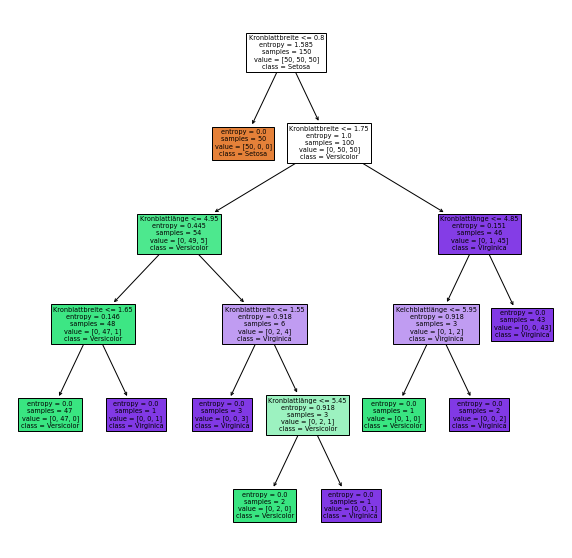

In [ ]:
# sklearn-Modul mit Irisdaten importieren
from sklearn.datasets import load_iris

# und die DataFrames mit erklärenden Variablen in X 
# und die mit der vorherzusagenden Variable in y speichern
X, y = load_iris(return_X_y=True, as_frame=True)

iris_features=['Kelchblattlänge', 'Kelchblattbreite', 'Kronblattlänge', 'Kronblattbreite']
iris_klassen = ['Setosa','Versicolor','Virginica']

baum = tree.DecisionTreeClassifier(criterion='entropy')
baum.fit(X, y)

# Baum grafisch darstellen
pyplot.figure(figsize=(10,10))
tmp = tree.plot_tree(baum,feature_names=iris_features,class_names=iris_klassen,filled=True)



Hier sehen Sie eine Version, bei der dieser Baum stark vereinfach ist: 

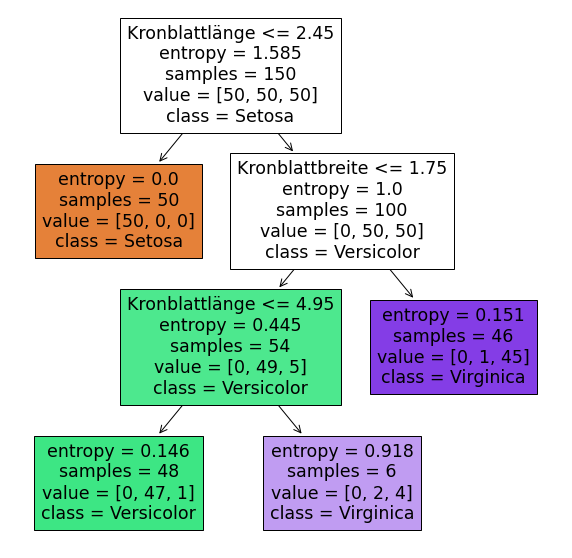

Versuchen Sie durch Angabe der oben besprochenen Parameter denselben Baum zu erstellen wie hier gezeigt. Dabei darf am obersten Knoten selbstverständlich statt der Kronblattlänge auch die Kronblattbreite als Aufteilungskriterium dienen. 

Es geht aber darum, dass der Baum ansonsten dieselbe Struktur hat wie der Baum oben: dass alle Setosas direkt in einem Blatt (korrekt) klassifiziert werden (links oben), dass fast alle Exemplare von Versicolor und sehr wenige Exemplare (hier eines) von Virginica im Blatt links unten landen, und dass das Blatt rechts davon sowohl einige Versicolors als auch einige Virginicas enthält. Die meisten Virginicas sollen im Blatt ganz rechts sein, mit maximal wenigen Exemplaren von Versicolor, wie in diesem Baum. 

Übernehmen Sie dazu den Code ohne Parameter von oben. Nehmen Sie sich dann einen Parameter nach dem andern vor und geben Sie ihn bei der Initialisierung des Baums an. Probieren Sie für jeden Parameter verschiedene Werte aus. Versuchen Sie, einen Baum mit der gewünschten einfachen Struktur zu erhalten. 

Mithilfe welcher Parameter ist das möglich? 

Und welcher Wert muss jeweils angegeben werden? 


## Tiefe

In der folgenden Zelle finden Sie den Code aus dem Abschnitt Vorbereitung. Ergänzen Sie den Parameter für die Baumtiefe. Probieren Sie aus, ob es Werte für diesen Parameter gibt, mit denen Sie den erwünschten einfacheren Baum erhalten.  

In [ ]:
baum = tree.DecisionTreeClassifier(criterion='entropy')
baum.fit(X, y)

# Baum grafisch darstellen
pyplot.figure(figsize=(10,10))
tmp = tree.plot_tree(baum,feature_names=iris_features,class_names=iris_klassen,filled=True)


## Antwort

Schreiben Sie hier Ihr Ergebnis auf. 

## Maximale Zahl von Blättern

In [ ]:
# Kopieren Sie hier den Code hin und ersetzen Sie den Parameter für Baumtiefe 
# durch den für die maximale Zahl von Blättern

## Antwort

Schreiben Sie hier Ihr Ergebnis auf. 

## Mindestmenge von Datenpunkten für Aufteilung

In [ ]:
# ...

## Antwort

Schreiben Sie hier Ihr Ergebnis auf. 

## Mindestmenge von Datenpunkten an Blättern

In [ ]:
# ...


## Antwort 

Schreiben Sie hier Ihr Ergebnis auf. 

## Pruning

In [ ]:
# ...

## Antwort

Schreiben Sie hier Ihr Ergebnis auf. 